In [1]:
!pip install nbformat


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip freeze > ..//requirements.txt

In [3]:
from _spark import get_spark, _display
from transformations import transform
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

import pyspark.sql.functions as f
import pyspark.sql.types as t
import os
import findspark
import pandas as pd

findspark.init()

spark = get_spark()

## BigQuery links

- [BigQuery Table](https://console.cloud.google.com/bigquery?hl=pt-br&project=fiap-tech-challenge-3&ws=!1m0)
- [Storage](https://console.cloud.google.com/storage/browser/tech-challenge;tab=configuration?hl=pt-br&project=fiap-tech-challenge-3&prefix=&forceOnObjectsSortingFiltering=false)
- [IAM e admin](https://console.cloud.google.com/iam-admin/iam?hl=pt-br&project=fiap-tech-challenge-3)

### Refined Data

#### Fato

In [4]:
table_name = "fiap-tech-challenge-3.refined_pnad.tb_f_covid_2020"
df = spark.read \
    .format("bigquery") \
    .option("table", table_name) \
    .load()

_display(df\
            .groupBy('resultado_covid')\
            .agg(f.count('uf'))
            )


,resultado_covid,count(uf)
0,3,293
1,None,1488952
2,9,644
3,1,100845
4,4,1762


### Trusted Data

#### Fato

In [32]:
table_name = "fiap-tech-challenge-3.trusted_pnad.tb_f_covid_2020"
df = spark.read \
    .format("bigquery") \
    .option("table", table_name) \
    .load()

df.columns

['uf',
 'semana_mes',
 'mes',
 'area_domicilio',
 'idade',
 'sexo',
 'cor_raca',
 'escolaridade',
 'teve_febre',
 'teve_dificuldade_respirar',
 'teve_dor_cabeca',
 'teve_fadiga',
 'teve_perda_cheiro',
 'foi_posto_saude',
 'ficou_em_casa',
 'ficou_internado',
 'tem_plano_saude',
 'resultado_covid',
 'assalariado',
 'faixa_rendimento',
 'situacao_domicilio']

In [50]:
table_name = "fiap-tech-challenge-3.trusted_pnad.tb_f_covid_2020"
df = spark.read \
    .format("bigquery") \
    .option("table", table_name) \
    .load()

# Remover NA e Não Sabe/Ignorado
for col in df.columns:
    df = df.withColumn(col, f.when(f.col(col).isin(['NA','Não sabe','Ignorado']), None).otherwise(f.col(col)))
_display(df\
        .groupBy('resultado_covid')\
        .agg(f.count('uf'))
        )
df = df.select(['uf','semana_mes','mes', 'area_domicilio','idade', 'sexo', 'cor_raca', 'escolaridade',
                'teve_febre','teve_dificuldade_respirar', 'teve_dor_cabeca',
                'teve_fadiga', 'teve_perda_cheiro',
                'tem_plano_saude','situacao_domicilio',
                'resultado_covid',])
df2 = df.toPandas()

# dropando na (menos de 10% da base)
df = df2.dropna()

In [51]:
df2.isna().sum()

uf                                0
semana_mes                        0
mes                               0
area_domicilio                    0
idade                             0
sexo                              0
cor_raca                        274
escolaridade                      0
teve_febre                   383766
teve_dificuldade_respirar      4210
teve_dor_cabeca                4275
teve_fadiga                    4275
teve_perda_cheiro              4985
tem_plano_saude              379279
situacao_domicilio           350603
resultado_covid              738397
dtype: int64

In [52]:
df.columns

Index(['uf', 'semana_mes', 'mes', 'area_domicilio', 'idade', 'sexo',
       'cor_raca', 'escolaridade', 'teve_febre', 'teve_dificuldade_respirar',
       'teve_dor_cabeca', 'teve_fadiga', 'teve_perda_cheiro',
       'tem_plano_saude', 'situacao_domicilio', 'resultado_covid'],
      dtype='object')


r2_score = -0.5901899707409037
precision_score = 0.4551484523057486
f1_score = 0.5428517611602939
roc_auc_score = 0.6735671327361256

classification_report =               precision    recall  f1-score   support

           0       0.84      0.67      0.75      5303
           1       0.46      0.67      0.54      2143

    accuracy                           0.67      7446
   macro avg       0.65      0.67      0.64      7446
weighted avg       0.73      0.67      0.69      7446




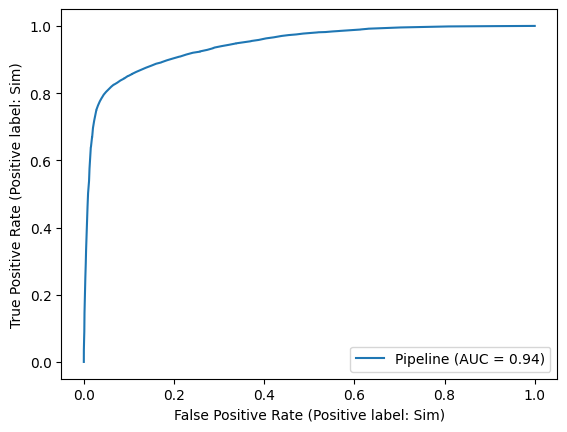

In [53]:
from sklearn.metrics import (  r2_score
                             , precision_score
                             , f1_score
                             , classification_report
                             , roc_auc_score
                             , RocCurveDisplay
                             )
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
import plotly.express as px

_features = ['uf', 
             'semana_mes', 
             'mes', 
             'area_domicilio', 
             'idade', 
             'sexo',
             'cor_raca', 
             'escolaridade', 
             'teve_febre', 
             'teve_dificuldade_respirar',
             'teve_dor_cabeca', 
             'teve_fadiga', 
             'teve_perda_cheiro',
             'tem_plano_saude',
             'situacao_domicilio']

pipeline = Pipeline(
    steps = [
        ('under', RandomUnderSampler(sampling_strategy='majority')),
        ('one-hot', OneHotEncoder(handle_unknown='infrequent_if_exist')),
        ('model',RandomForestClassifier(random_state=42))
    ]
)

X = df[_features]
y = df[['resultado_covid']]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
pipeline.fit(X_train, y_train)

model = pipeline['model']
y_pred = pipeline.predict(X_test)

_y_test = [int(x.replace('Não','0').replace('Sim','1')) for x in y_test['resultado_covid'].to_list()]
_y_pred = [int(x.replace('Não','0').replace('Sim','1')) for x in y_pred]

print(f"""
r2_score = {r2_score(_y_test, _y_pred)}
precision_score = {precision_score(_y_test, _y_pred)}
f1_score = {f1_score(_y_test, _y_pred)}
roc_auc_score = {roc_auc_score(_y_test, _y_pred)}

classification_report = {classification_report(_y_test, _y_pred)}
""")

RocCurveDisplay.from_estimator(pipeline, X, y)

result = permutation_importance(
    pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.DataFrame([result.importances_mean, X.columns], index=['importance','feature']).T


fig = px.bar(
    forest_importances.sort_values('importance'),
    x='importance', y='feature', orientation='h'
)
fig.update_layout(
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True
    ),
    xaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True
    )
)
fig.show()


r2_score = -0.9833148089957624
precision_score = 0.3637484586929716
f1_score = 0.43809170224614813
roc_auc_score = 0.5807081526766781

classification_report =               precision    recall  f1-score   support

           0       0.77      0.61      0.68      5303
           1       0.36      0.55      0.44      2143

    accuracy                           0.59      7446
   macro avg       0.57      0.58      0.56      7446
weighted avg       0.65      0.59      0.61      7446




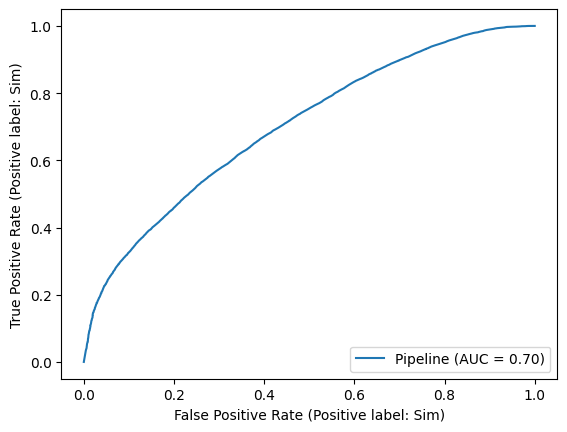

In [55]:
from sklearn.metrics import (  r2_score
                             , precision_score
                             , f1_score
                             , classification_report
                             , roc_auc_score
                             , RocCurveDisplay
                             )
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
import plotly.express as px

_features = ['uf', 
             'area_domicilio', 
             'sexo', 
             'cor_raca', 
             'escolaridade',
             'teve_dificuldade_respirar', 
             'teve_dor_cabeca', 
             'teve_fadiga',
             'teve_perda_cheiro']

pipeline = Pipeline(
    steps = [
        ('under', RandomUnderSampler(sampling_strategy='majority')),
        ('one-hot', OneHotEncoder(handle_unknown='infrequent_if_exist')),
        ('model',RandomForestClassifier(random_state=42))
    ]
)

X = df[_features]
y = df[['resultado_covid']]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
pipeline.fit(X_train, y_train)

model = pipeline['model']
y_pred = pipeline.predict(X_test)

_y_test = [int(x.replace('Não','0').replace('Sim','1')) for x in y_test['resultado_covid'].to_list()]
_y_pred = [int(x.replace('Não','0').replace('Sim','1')) for x in y_pred]

print(f"""
r2_score = {r2_score(_y_test, _y_pred)}
precision_score = {precision_score(_y_test, _y_pred)}
f1_score = {f1_score(_y_test, _y_pred)}
roc_auc_score = {roc_auc_score(_y_test, _y_pred)}

classification_report = {classification_report(_y_test, _y_pred)}
""")

RocCurveDisplay.from_estimator(pipeline, X, y)

result = permutation_importance(
    pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.DataFrame([result.importances_mean, X.columns], index=['importance','feature']).T


fig = px.bar(
    forest_importances.sort_values('importance'),
    x='importance', y='feature', orientation='h'
)
fig.update_layout(
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True
    ),
    xaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True
    )
)
fig.show()


r2_score = -0.38445463872086094
precision_score = 0.5048480930833872
f1_score = 0.5965247278976512
roc_auc_score = 0.7199958308141202

classification_report =               precision    recall  f1-score   support

           0       0.87      0.71      0.78      5303
           1       0.50      0.73      0.60      2143

    accuracy                           0.72      7446
   macro avg       0.69      0.72      0.69      7446
weighted avg       0.76      0.72      0.73      7446




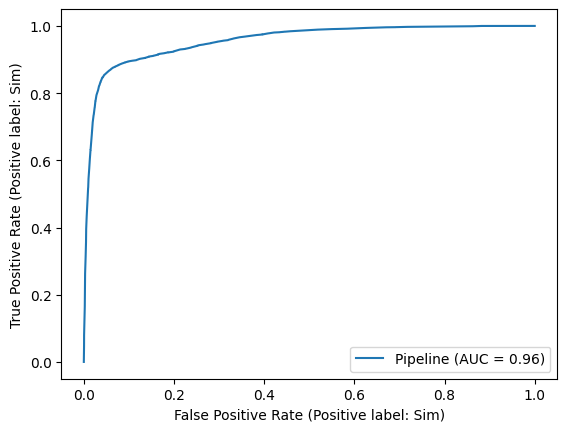

In [57]:
from sklearn.metrics import (  r2_score
                             , precision_score
                             , f1_score
                             , classification_report
                             , roc_auc_score
                             , RocCurveDisplay
                             )
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
import plotly.express as px

_features = ['uf', 'semana_mes',
             'area_domicilio', 
             'idade', 
             'sexo',
             'cor_raca', 
             'escolaridade', 
             'teve_febre', 
             'teve_dificuldade_respirar',
             'teve_dor_cabeca', 
             'teve_fadiga', 
             'teve_perda_cheiro',
             'tem_plano_saude',
             'situacao_domicilio']

pipeline = Pipeline(
    steps = [
        ('under', RandomUnderSampler(sampling_strategy='majority')),
        ('one-hot', OneHotEncoder(handle_unknown='infrequent_if_exist')),
        ('model',RandomForestClassifier(random_state=42))
    ]
)

X = df[_features]
y = df[['resultado_covid']]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
pipeline.fit(X_train, y_train)

model = pipeline['model']
y_pred = pipeline.predict(X_test)

_y_test = [int(x.replace('Não','0').replace('Sim','1')) for x in y_test['resultado_covid'].to_list()]
_y_pred = [int(x.replace('Não','0').replace('Sim','1')) for x in y_pred]

print(f"""
r2_score = {r2_score(_y_test, _y_pred)}
precision_score = {precision_score(_y_test, _y_pred)}
f1_score = {f1_score(_y_test, _y_pred)}
roc_auc_score = {roc_auc_score(_y_test, _y_pred)}

classification_report = {classification_report(_y_test, _y_pred)}
""")

RocCurveDisplay.from_estimator(pipeline, X, y)

result = permutation_importance(
    pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.DataFrame([result.importances_mean, X.columns], index=['importance','feature']).T


fig = px.bar(
    forest_importances.sort_values('importance'),
    x='importance', y='feature', orientation='h'
)
fig.update_layout(
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True
    ),
    xaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True
    )
)
fig.show()